In [35]:
pip install pandas matplotlib numpy scikit-learn tensorflow keras xgboost TA-lib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Epoch 1/50


C:\Users\samue\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1484 - val_loss: 0.0894
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0600 - val_loss: 0.0820
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0488 - val_loss: 0.0769
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0454 - val_loss: 0.0743
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0387 - val_loss: 0.0772
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0423 - val_loss: 0.0676
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0344 - val_loss: 0.0604
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0352 - val_loss: 0.0593
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0313 - val_loss: 0.0537
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0307 - val_loss: 0.0619
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0273 - val_loss: 0.0503
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0309 - val_l

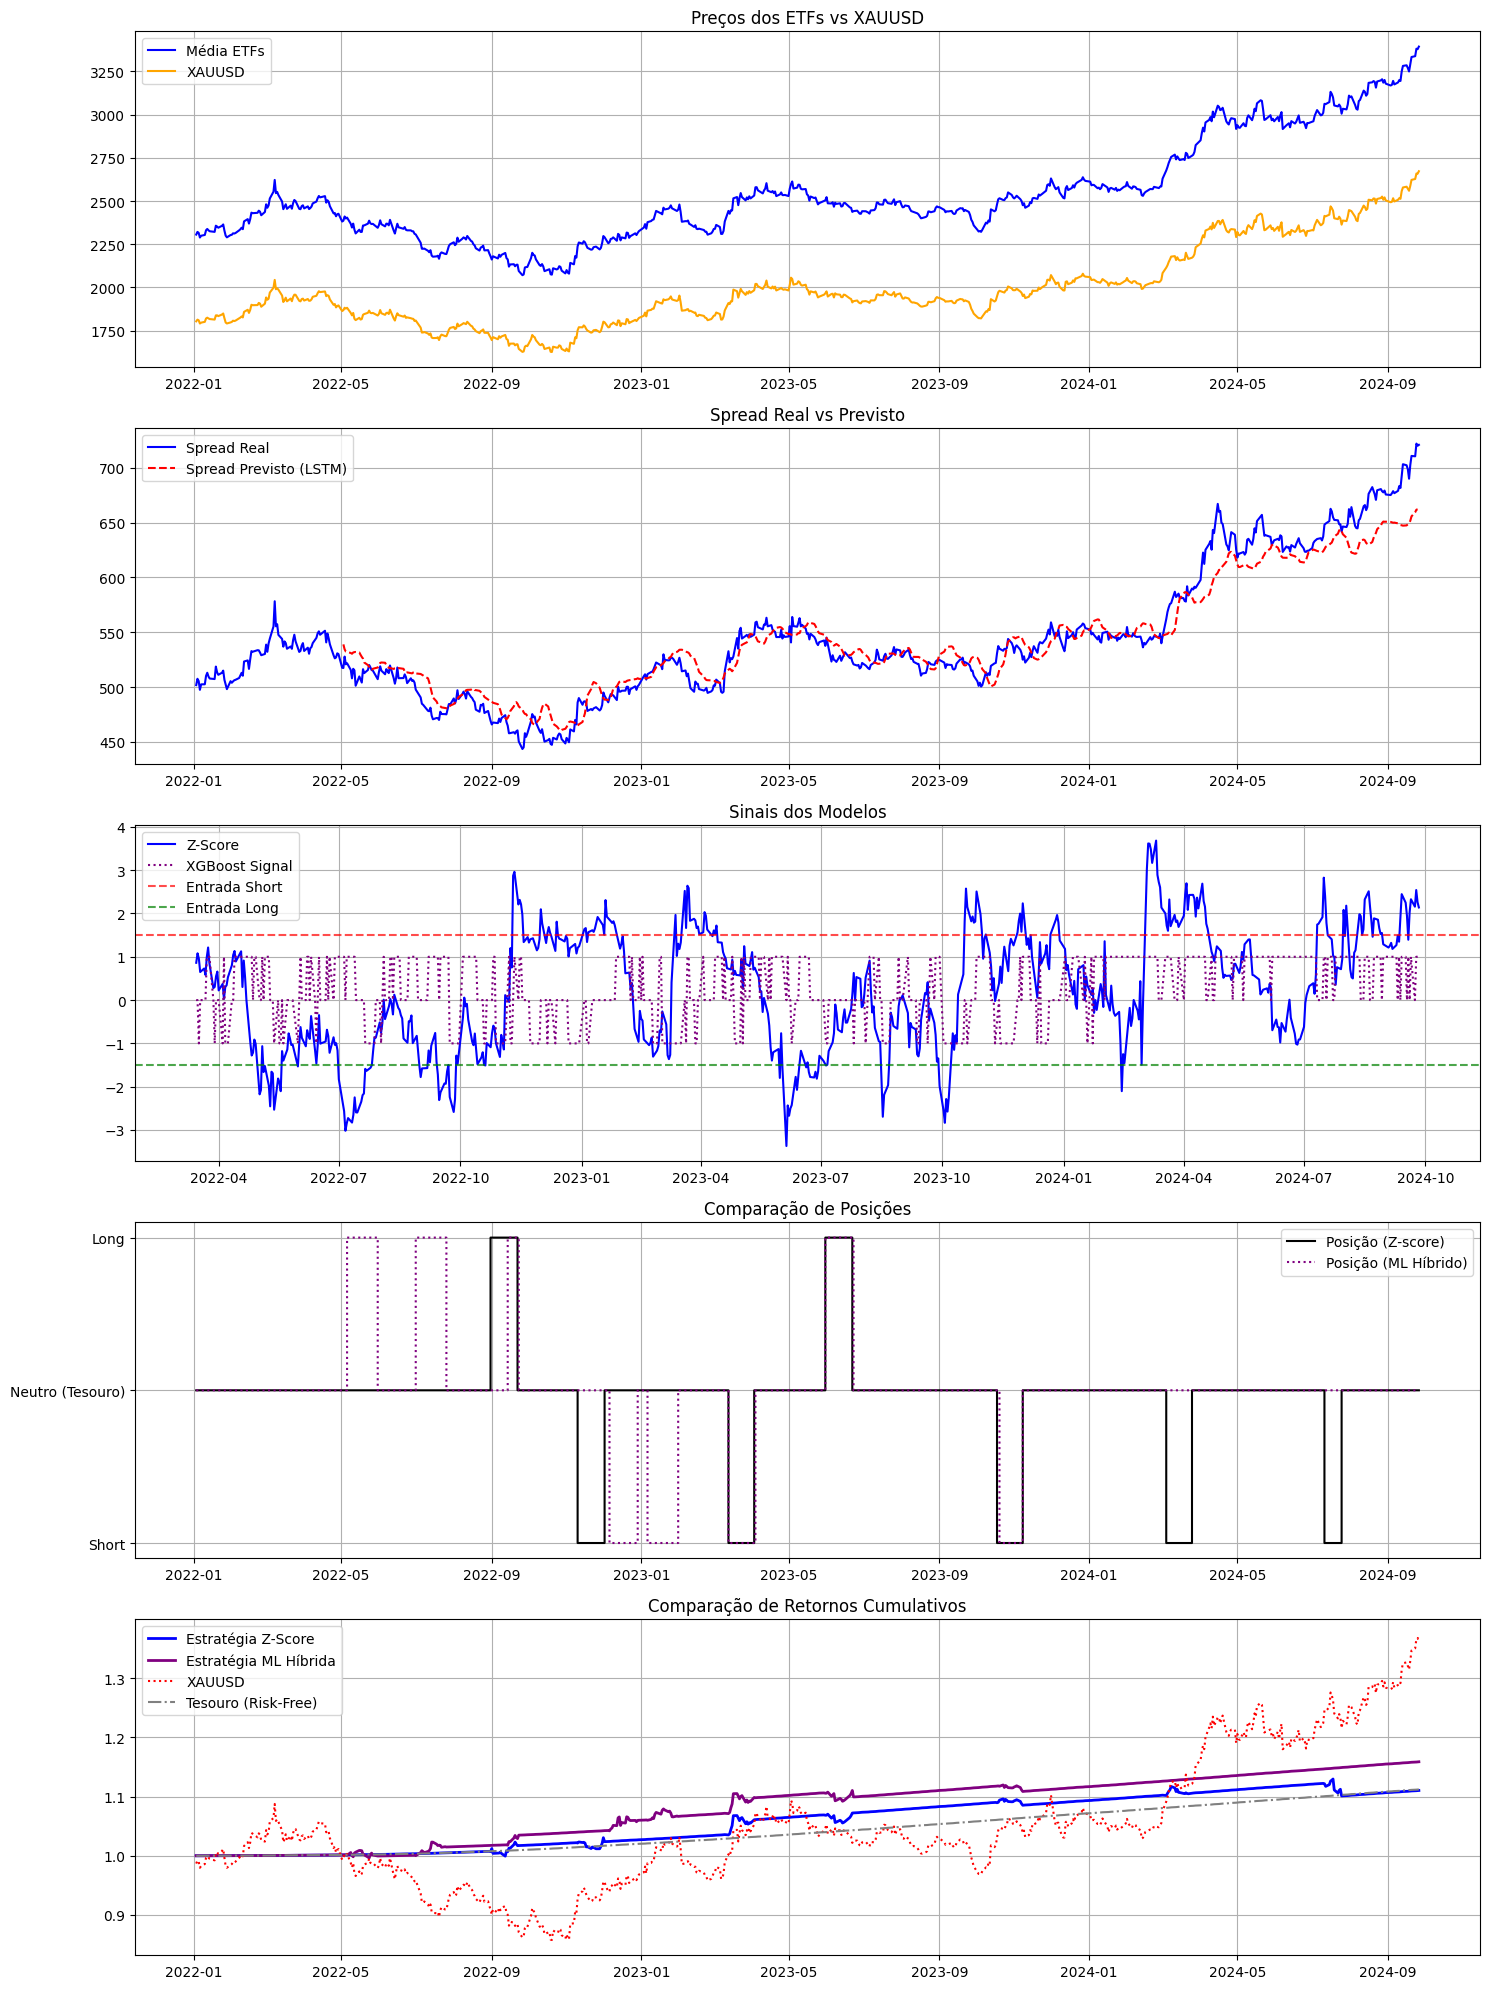


===== RESULTADOS COMPARATIVOS =====

[Estratégia Z-Score Tradicional]
Retorno acumulado: 11.03%
Retorno anualizado: 3.91%
Volatilidade anualizada: 2.74%
Índice de Sharpe: 0.01
Drawdown máximo: -2.54%
Total de trades: 15
Trades por ano: 5.5
% tempo investido em tesouro: 85.4%

[Estratégia ML Híbrida]
Retorno acumulado: 15.88%
Retorno anualizado: 5.56%
Volatilidade anualizada: 2.86%
Índice de Sharpe: 0.58
Drawdown máximo: -1.40%
Total de trades: 17
Trades por ano: 6.2
% tempo investido em tesouro: 83.1%

[Comparativo de Mercado]
Buy & Hold PAXG: 26.60%
Buy & Hold XAUUSD: 37.37%
Buy & Hold Tesouro: 11.21%


In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix

###############################################
# 1. Carregamento e Preparação dos Dados
###############################################
base_folder = r"C:\Users\samue\Documents\projeto Quant-H2\compiled_data"

# Carrega os dados diários
gld    = pd.read_csv(os.path.join(base_folder, "GLD_daily.csv"), index_col=0, parse_dates=True)
iau    = pd.read_csv(os.path.join(base_folder, "IAU_daily.csv"), index_col=0, parse_dates=True)
paxg   = pd.read_csv(os.path.join(base_folder, "PAXG_daily.csv"), index_col=0, parse_dates=True)
xauusd = pd.read_csv(os.path.join(base_folder, "XAUUSD_daily.csv"), index_col=0, parse_dates=True)
fred   = pd.read_csv(os.path.join(base_folder, "fred_interest_rates.csv"), index_col=0, parse_dates=True)

# Define o período de análise
start = pd.to_datetime("2022-01-01")
end   = pd.to_datetime("2025-01-01")

gld    = gld[(gld.index >= start) & (gld.index < end)]
iau    = iau[(iau.index >= start) & (iau.index < end)]
paxg   = paxg[(paxg.index >= start) & (paxg.index < end)]
xauusd = xauusd[(xauusd.index >= start) & (xauusd.index < end)]
fred   = fred[(fred.index >= start) & (fred.index < end)]

###############################################
# 2. Ajuste de Escalas e Alinhamento dos Dados
###############################################
# Ajuste para preço por onça
gld["price_oz"] = gld["close"] * 10
iau["price_oz"] = iau["close"] * 100
paxg["price_oz"] = paxg["close"]

# Alinhamento dos dados
common_dates = gld.index.intersection(iau.index).intersection(paxg.index).intersection(xauusd.index)
gld    = gld.loc[common_dates]
iau    = iau.loc[common_dates]
paxg   = paxg.loc[common_dates]
xauusd = xauusd.loc[common_dates]

# Preparação da taxa livre de risco
business_dates = pd.date_range(start, end, freq='B')
fred = fred.sort_index().reindex(business_dates, method='ffill')
fred["risk_free"] = (1 + fred["close"] / 100) ** (1/252) - 1
fred_risk = fred["risk_free"].reindex(common_dates, method='ffill')

###############################################
# 3. Criação do DataFrame Unificado
###############################################
df = pd.DataFrame(index=common_dates)
df["GLD"]    = gld["price_oz"]
df["IAU"]    = iau["price_oz"]
df["PAXG"]   = paxg["price_oz"]
df["XAUUSD"] = xauusd["close"]
df["avg_etf"] = df[["GLD", "IAU", "PAXG"]].mean(axis=1)
df["spread"] = df["avg_etf"] - df["XAUUSD"]
df["risk_free"] = fred_risk

###############################################
# 4. Cálculo de Indicadores Técnicos
###############################################
# Z-score do spread com múltiplas janelas
window_short = 20
window_medium = 50
window_long = 100
window_z = window_medium  # Janela padrão para referências

# Z-scores para diferentes períodos
df["spread_ma_short"] = df["spread"].rolling(window=window_short).mean()
df["spread_std_short"] = df["spread"].rolling(window=window_short).std()
df["z_score_short"] = (df["spread"] - df["spread_ma_short"]) / df["spread_std_short"].replace(0, np.nan)

df["spread_ma"] = df["spread_ma_med"] = df["spread"].rolling(window=window_medium).mean()
df["spread_std"] = df["spread_std_med"] = df["spread"].rolling(window=window_medium).std()
df["z_score"] = df["z_score_med"] = (df["spread"] - df["spread_ma_med"]) / df["spread_std_med"].replace(0, np.nan)

df["spread_ma_long"] = df["spread"].rolling(window=window_long).mean()
df["spread_std_long"] = df["spread"].rolling(window=window_long).std() 
df["z_score_long"] = (df["spread"] - df["spread_ma_long"]) / df["spread_std_long"].replace(0, np.nan)

# Tendência do ouro e momentum do spread
df["xauusd_ma20"] = df["XAUUSD"].rolling(window=20).mean()
df["xauusd_ma50"] = df["XAUUSD"].rolling(window=50).mean()
df["xauusd_trend"] = np.where(df["xauusd_ma20"] > df["xauusd_ma50"], 1, -1)
df["spread_momentum"] = df["spread"].pct_change(5)
df["spread_vol"] = df["spread"].rolling(window=20).std() / abs(df["spread_ma"]).replace(0, np.nan)

###############################################
# 5. Preparação de Dados para Modelos Preditivos
###############################################
# Parâmetros para os modelos
lookback_days = 30
forecast_horizon = 5  # Prevemos o spread 5 dias à frente

# Função para criar sequências para LSTM
def create_sequences(data, seq_length, horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - horizon):
        X.append(data[i:(i + seq_length)])
        # Target: spread futuro
        y.append(data[i + seq_length + horizon - 1])
    return np.array(X), np.array(y)

# Preparar dados para LSTM (previsão de spread)
features = df[['spread', 'z_score', 'spread_momentum', 'xauusd_trend']].dropna()
feature_scaler = MinMaxScaler()
features_scaled = feature_scaler.fit_transform(features)

# Criar sequências para LSTM e dividir em treino/teste
X_seq, y_seq = create_sequences(features_scaled, lookback_days, forecast_horizon)
X_seq = X_seq.reshape(X_seq.shape[0], lookback_days, features.shape[1])
split_idx = int(0.7 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

###############################################
# 6. Modelo LSTM para Previsão do Spread
###############################################
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback_days, features.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.1),
    Dense(features.shape[1])  # Prever todas as features
])

lstm_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Fazer previsões
all_seq, _ = create_sequences(features_scaled, lookback_days, forecast_horizon)
all_seq = all_seq.reshape(-1, lookback_days, features.shape[1])
predictions = lstm_model.predict(all_seq)

# Processar previsões
spread_predictions = feature_scaler.inverse_transform(predictions)[:, 0]
pred_indices = features.index[lookback_days + forecast_horizon - 1:lookback_days + forecast_horizon - 1 + len(spread_predictions)]
predicted_spreads = pd.Series(spread_predictions, index=pred_indices, name='predicted_spread')
df = df.join(predicted_spreads)

###############################################
# 7. Modelo XGBoost para Classificação
###############################################
# Preparação dos dados para XGBoost
features_for_xgb = features.copy()
features_for_xgb['future_return'] = df['spread'].shift(-forecast_horizon) - df['spread']
features_for_xgb['target'] = 0  # Inicializa como neutro

# Define targets para classificação
threshold_up = features_for_xgb['future_return'].quantile(0.7)
threshold_down = features_for_xgb['future_return'].quantile(0.3)
features_for_xgb.loc[features_for_xgb['future_return'] > threshold_up, 'target'] = -1  # Short
features_for_xgb.loc[features_for_xgb['future_return'] < threshold_down, 'target'] = 1  # Long

# Preparar X e y para treinamento
features_for_xgb = features_for_xgb.drop(['future_return'], axis=1).dropna()
X = features_for_xgb.drop(['target'], axis=1)
y = features_for_xgb['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Treinar modelo XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train, y_train + 1)  # +1 para classes não-negativas

# Avaliar e fazer predições
test_preds = xgb_model.predict(X_test)
test_preds = test_preds - 1
print(f"Acurácia do XGBoost: {accuracy_score(y_test, test_preds):.4f}")
print("Matriz de confusão:")
print(confusion_matrix(y_test, test_preds))

# Predições para todo o dataset
all_preds = xgb_model.predict(X)
all_preds = all_preds - 1
df['xgb_signal'] = pd.Series(all_preds, index=X.index)

###############################################
# 8. Parâmetros da Estratégia
###############################################
# Parâmetros para entrada/saída
z_entry_threshold = 1.5
z_exit_threshold = 0.5
max_days_in_position = 15
transaction_cost = 0.0007  # 7 basis points

# Inicialização
df["position"] = 0  # Z-score tradicional
df["ml_position"] = 0  # Estratégia híbrida ML

###############################################
# 9. Estratégia Z-Score Tradicional
###############################################
position_days = 0

for i in range(window_long, len(df)):
    prev_pos = df["position"].iloc[i-1]
    z = df["z_score"].iloc[i]
    trend = df["xauusd_trend"].iloc[i]
    
    if prev_pos != 0:
        position_days += 1
    else:
        position_days = 0
    
    if position_days >= max_days_in_position:
        df.iloc[i, df.columns.get_loc("position")] = 0
        position_days = 0
        continue
    
    if prev_pos == 0:
        if z < -z_entry_threshold and trend == 1:
            df.iloc[i, df.columns.get_loc("position")] = 1  # Long ETF/Short XAUUSD
        elif z > z_entry_threshold and trend == -1:
            df.iloc[i, df.columns.get_loc("position")] = -1  # Short ETF/Long XAUUSD
        else:
            df.iloc[i, df.columns.get_loc("position")] = 0  # Neutro (Tesouro)
    
    elif prev_pos == 1:
        if z > -z_exit_threshold:
            df.iloc[i, df.columns.get_loc("position")] = 0
        else:
            df.iloc[i, df.columns.get_loc("position")] = 1
    
    elif prev_pos == -1:
        if z < z_exit_threshold:
            df.iloc[i, df.columns.get_loc("position")] = 0
        else:
            df.iloc[i, df.columns.get_loc("position")] = -1

###############################################
# 10. Estratégia Híbrida (Z-Score + ML)
###############################################
position_days = 0

for i in range(max(window_z, lookback_days + forecast_horizon), len(df)):
    prev_pos = df["ml_position"].iloc[i-1]
    z = df["z_score"].iloc[i]
    
    # Sinais dos modelos preditivos
    try:
        pred_spread = df["predicted_spread"].iloc[i]
        xgb_signal = df["xgb_signal"].iloc[i]
    except:
        pred_spread = np.nan
        xgb_signal = 0
        
    # Calculamos o z-score do spread previsto
    trend = df["xauusd_trend"].iloc[i]
    current_mean = df["spread_ma"].iloc[i]
    current_std = df["spread_std"].iloc[i]
    if not np.isnan(pred_spread) and current_std > 0:
        future_z = (pred_spread - current_mean) / current_std
    else:
        future_z = 0
    
    # Rastreamos dias na posição
    if prev_pos != 0:
        position_days += 1
    else:
        position_days = 0
        
    # Stop por tempo máximo na posição
    if position_days > max_days_in_position:
        df.iloc[i, df.columns.get_loc("ml_position")] = 0
        position_days = 0
        continue
    
    # Lógica híbrida de posicionamento
    if prev_pos == 0:  # Neutro (Tesouro)
        # Confirmação multi-modelo para entrada
        if z < -z_entry_threshold and xgb_signal == 1 and (trend == 1 or future_z < 0):
            # ETFs baratos + ML prevê subida
            df.iloc[i, df.columns.get_loc("ml_position")] = 1
        elif z > z_entry_threshold and xgb_signal == -1 and (trend == -1 or future_z > 0):
            # ETFs caros + ML prevê queda
            df.iloc[i, df.columns.get_loc("ml_position")] = -1
        else:
            df.iloc[i, df.columns.get_loc("ml_position")] = 0
    
    elif prev_pos == 1:  # Long
        if (z > -z_exit_threshold) or (xgb_signal == -1 and future_z > 0):
            df.iloc[i, df.columns.get_loc("ml_position")] = 0
        else:
            df.iloc[i, df.columns.get_loc("ml_position")] = 1
    
    elif prev_pos == -1:  # Short
        if (z < z_exit_threshold) or (xgb_signal == 1 and future_z < 0):
            df.iloc[i, df.columns.get_loc("ml_position")] = 0
        else:
            df.iloc[i, df.columns.get_loc("ml_position")] = -1

###############################################
# 11. Cálculo dos Retornos
###############################################
# Retornos diários dos ativos
gld["ret"] = (gld["close"] / gld["open"]) - 1
iau["ret"] = (iau["close"] / iau["open"]) - 1
paxg["ret"] = (paxg["close"] / paxg["open"]) - 1
xauusd["ret"] = (xauusd["close"] / xauusd["open"]) - 1
df["etf_ret"] = (gld["ret"] + iau["ret"] + paxg["ret"]) / 3.0
df["xauusd_ret"] = xauusd["ret"]

# Retornos para estratégia Z-score tradicional
df["trade"] = df["position"] != df["position"].shift(1)
df["cost"] = np.where(df["trade"], transaction_cost, 0)

# Quando neutros, investimos no tesouro americano (risk_free)
df["strategy_ret"] = np.where(
    df["position"].shift(1) == 0,
    df["risk_free"] - df["cost"],
    df["position"].shift(1) * (df["etf_ret"] - df["xauusd_ret"]) - df["cost"]
)

df["cum_strategy"] = (1 + df["strategy_ret"].fillna(0)).cumprod()

# Retornos para estratégia ML híbrida
df["ml_trade"] = df["ml_position"] != df["ml_position"].shift(1)
df["ml_cost"] = np.where(df["ml_trade"], transaction_cost, 0)

# Quando neutros, investimos no tesouro americano (risk_free)
df["ml_strategy_ret"] = np.where(
    df["ml_position"].shift(1) == 0,
    df["risk_free"] - df["ml_cost"],
    df["ml_position"].shift(1) * (df["etf_ret"] - df["xauusd_ret"]) - df["ml_cost"]
)

df["cum_ml_strategy"] = (1 + df["ml_strategy_ret"].fillna(0)).cumprod()

# Retorno buy & hold
cum_gld = (1 + gld["ret"]).cumprod()
cum_iau = (1 + iau["ret"]).cumprod()
cum_paxg = (1 + paxg["ret"]).cumprod()
cum_xauusd = (1 + xauusd["ret"]).cumprod()
cum_riskfree = (1 + df["risk_free"]).cumprod()

###############################################
# 12. Métricas de Performance
###############################################
# Estatísticas para estratégia tradicional
years = len(df) / 252
annual_return = (df["cum_strategy"].iloc[-1] ** (1/years) - 1) * 100
daily_vol = df["strategy_ret"].std()
annual_vol = daily_vol * np.sqrt(252) * 100
avg_rf = df["risk_free"].mean() * 252 * 100
sharpe_ratio = (annual_return - avg_rf) / annual_vol if annual_vol > 0 else 0
df["peak"] = df["cum_strategy"].cummax()
df["drawdown"] = (df["cum_strategy"] / df["peak"] - 1) * 100
max_drawdown = df["drawdown"].min()
total_trades = df["trade"].sum()
trades_per_year = total_trades / years

# Estatísticas para estratégia ML
ml_annual_return = (df["cum_ml_strategy"].iloc[-1] ** (1/years) - 1) * 100
ml_daily_vol = df["ml_strategy_ret"].std()
ml_annual_vol = ml_daily_vol * np.sqrt(252) * 100
ml_sharpe_ratio = (ml_annual_return - avg_rf) / ml_annual_vol if ml_annual_vol > 0 else 0
df["ml_peak"] = df["cum_ml_strategy"].cummax()
df["ml_drawdown"] = (df["cum_ml_strategy"] / df["ml_peak"] - 1) * 100
ml_max_drawdown = df["ml_drawdown"].min()
ml_total_trades = df["ml_trade"].sum()
ml_trades_per_year = ml_total_trades / years

###############################################
# 13. Visualização Comparativa
###############################################
plt.figure(figsize=(15, 20))

# Subplot 1: Preços e Spread
plt.subplot(5, 1, 1)
plt.plot(df.index, df["avg_etf"], label="Média ETFs", color="blue")
plt.plot(df.index, df["XAUUSD"], label="XAUUSD", color="orange")
plt.title("Preços dos ETFs vs XAUUSD")
plt.legend()
plt.grid(True)

# Subplot 2: Spread Real vs Previsto
plt.subplot(5, 1, 2)
plt.plot(df.index, df["spread"], label="Spread Real", color="blue")
plt.plot(df.index, df["predicted_spread"], label="Spread Previsto (LSTM)", color="red", linestyle="--")
plt.title("Spread Real vs Previsto")
plt.legend()
plt.grid(True)

# Subplot 3: Sinais dos Modelos
plt.subplot(5, 1, 3)
plt.plot(df.index, df["z_score"], label="Z-Score", color="blue")
plt.plot(df.index, df["xgb_signal"], label="XGBoost Signal", color="purple", linestyle=":")
plt.axhline(y=z_entry_threshold, color='r', linestyle='--', alpha=0.7, label=f'Entrada Short')
plt.axhline(y=-z_entry_threshold, color='g', linestyle='--', alpha=0.7, label=f'Entrada Long')
plt.title("Sinais dos Modelos")
plt.legend()
plt.grid(True)

# Subplot 4: Posições (Tradicional vs ML)
plt.subplot(5, 1, 4)
plt.plot(df.index, df["position"], label="Posição (Z-score)", color="black", drawstyle="steps-post")
plt.plot(df.index, df["ml_position"], label="Posição (ML Híbrido)", color="purple", drawstyle="steps-post", linestyle=":")
plt.title("Comparação de Posições")
plt.yticks([-1, 0, 1], ["Short", "Neutro (Tesouro)", "Long"])
plt.legend()
plt.grid(True)

# Subplot 5: Retornos Cumulativos
plt.subplot(5, 1, 5)
plt.plot(df.index, df["cum_strategy"], label="Estratégia Z-Score", color="blue", linewidth=2)
plt.plot(df.index, df["cum_ml_strategy"], label="Estratégia ML Híbrida", color="purple", linewidth=2)
plt.plot(df.index, cum_xauusd, label="XAUUSD", linestyle=":", color="red")
plt.plot(df.index, cum_riskfree, label="Tesouro (Risk-Free)", linestyle="-.", color="gray")
plt.title("Comparação de Retornos Cumulativos")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

###############################################
# 14. Resultados Comparativos
###############################################
print("\n===== RESULTADOS COMPARATIVOS =====")
print("\n[Estratégia Z-Score Tradicional]")
print("Retorno acumulado: {:.2f}%".format((df["cum_strategy"].iloc[-1]-1)*100))
print("Retorno anualizado: {:.2f}%".format(annual_return))
print("Volatilidade anualizada: {:.2f}%".format(annual_vol))
print("Índice de Sharpe: {:.2f}".format(sharpe_ratio))
print("Drawdown máximo: {:.2f}%".format(max_drawdown))
print("Total de trades: {}".format(total_trades))
print("Trades por ano: {:.1f}".format(trades_per_year))
print("% tempo investido em tesouro: {:.1f}%".format(100 * (df["position"] == 0).sum() / len(df)))

print("\n[Estratégia ML Híbrida]")
print("Retorno acumulado: {:.2f}%".format((df["cum_ml_strategy"].iloc[-1]-1)*100))
print("Retorno anualizado: {:.2f}%".format(ml_annual_return))
print("Volatilidade anualizada: {:.2f}%".format(ml_annual_vol))
print("Índice de Sharpe: {:.2f}".format(ml_sharpe_ratio))
print("Drawdown máximo: {:.2f}%".format(ml_max_drawdown))
print("Total de trades: {}".format(ml_total_trades))
print("Trades por ano: {:.1f}".format(ml_trades_per_year))
print("% tempo investido em tesouro: {:.1f}%".format(100 * (df["ml_position"] == 0).sum() / len(df)))

print("\n[Comparativo de Mercado]")
print("Buy & Hold PAXG: {:.2f}%".format((cum_paxg.iloc[-1]-1)*100))
print("Buy & Hold XAUUSD: {:.2f}%".format((cum_xauusd.iloc[-1]-1)*100))
print("Buy & Hold Tesouro: {:.2f}%".format((cum_riskfree.iloc[-1]-1)*100))

Epoch 1/50


C:\Users\samue\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1567 - val_loss: 0.0359
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0491 - val_loss: 0.0734
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0484 - val_loss: 0.0480
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0373 - val_loss: 0.0495
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0367 - val_loss: 0.0537
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0352 - val_loss: 0.0499
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0335 - val_loss: 0.0488
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0345 - val_loss: 0.0672
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0328 - val_loss: 0.0622
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0330 - val_loss: 0.0599
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0335 - val_loss: 0.0552
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Acurácia do XGBoost: 0.2396


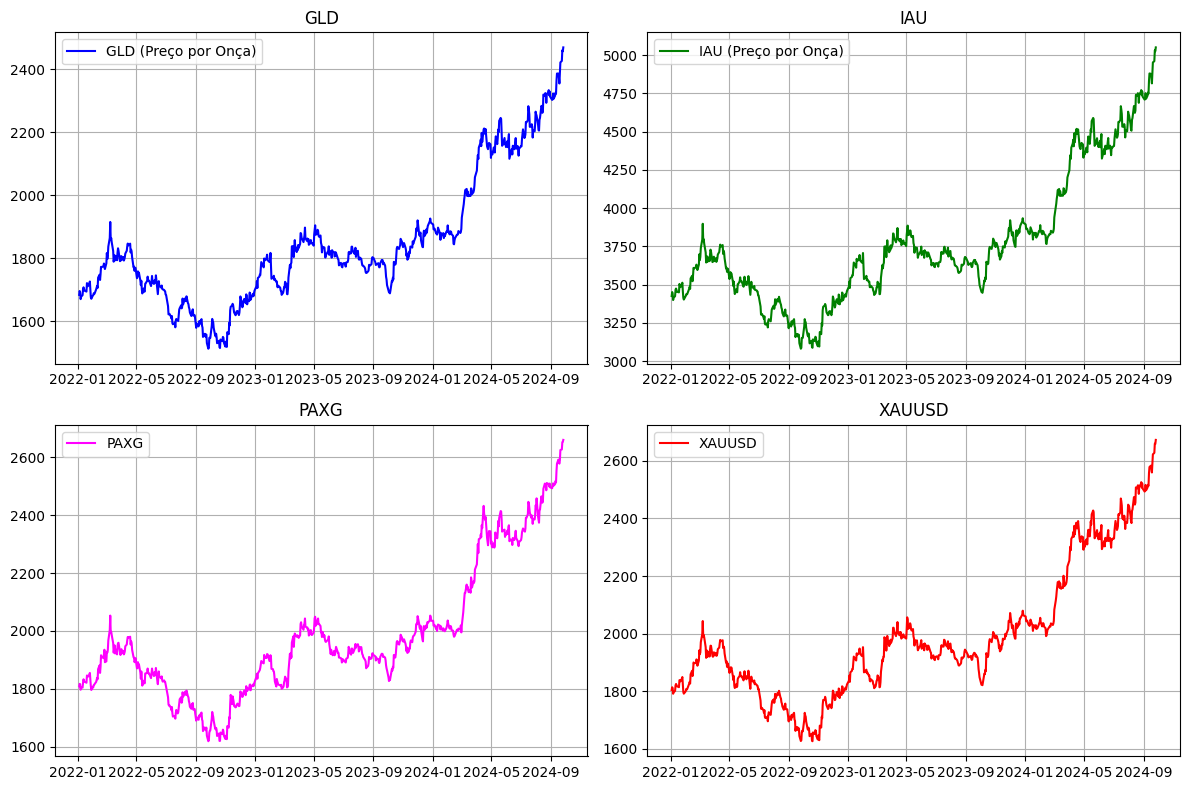

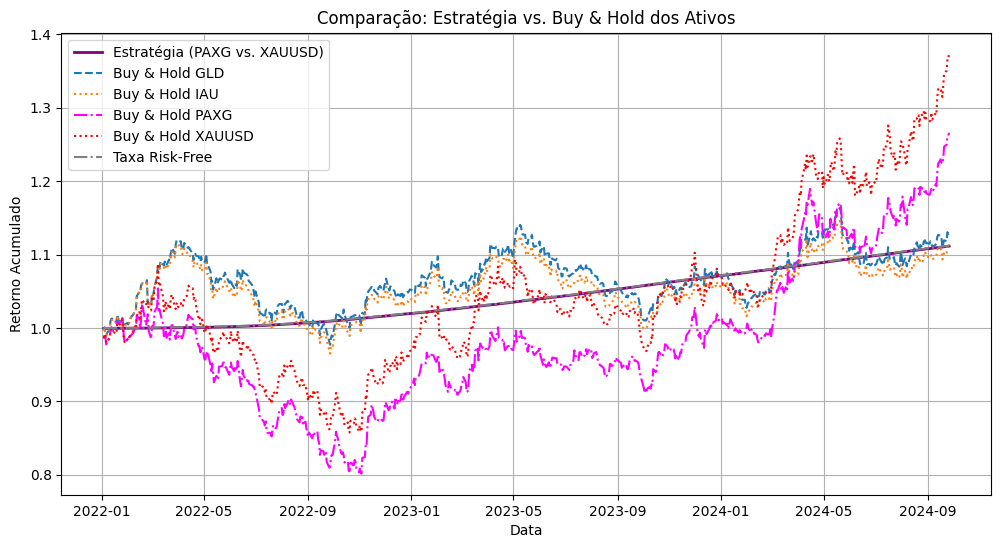


===== RESULTADOS COMPARATIVOS =====
Retorno acumulado da estratégia: 11.15%
Retorno acumulado - Buy & Hold GLD: 13.09%
Retorno acumulado - Buy & Hold IAU: 11.38%
Retorno acumulado - Buy & Hold PAXG: 26.60%
Retorno acumulado - Buy & Hold XAUUSD: 37.37%
Retorno acumulado - Taxa Risk-Free: 11.21%


In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
import talib

###############################################
# 1. Carregamento e Preparação dos Dados
###############################################
base_folder = r"C:\Users\samue\Documents\projeto Quant-H2\compiled_data"

# Carrega os dados diários
gld    = pd.read_csv(os.path.join(base_folder, "GLD_daily.csv"), index_col=0, parse_dates=True)
iau    = pd.read_csv(os.path.join(base_folder, "IAU_daily.csv"), index_col=0, parse_dates=True)
paxg   = pd.read_csv(os.path.join(base_folder, "PAXG_daily.csv"), index_col=0, parse_dates=True)
xauusd = pd.read_csv(os.path.join(base_folder, "XAUUSD_daily.csv"), index_col=0, parse_dates=True)
fred   = pd.read_csv(os.path.join(base_folder, "fred_interest_rates.csv"), index_col=0, parse_dates=True)

# Define o período de análise
start = pd.to_datetime("2022-01-01")
end   = pd.to_datetime("2025-01-01")

gld    = gld[(gld.index >= start) & (gld.index < end)]
iau    = iau[(iau.index >= start) & (iau.index < end)]
paxg   = paxg[(paxg.index >= start) & (paxg.index < end)]
xauusd = xauusd[(xauusd.index >= start) & (xauusd.index < end)]
fred   = fred[(fred.index >= start) & (fred.index < end)]

###############################################
# 2. Ajuste de Escalas e Alinhamento dos Dados
###############################################
# Ajuste para preço por onça
gld["price_oz"] = gld["close"] * 10
iau["price_oz"] = iau["close"] * 100
paxg["price_oz"] = paxg["close"]

# Alinhamento dos dados: usamos a interseção dos índices
common_dates = gld.index.intersection(iau.index).intersection(paxg.index).intersection(xauusd.index)
gld    = gld.loc[common_dates]
iau    = iau.loc[common_dates]
paxg   = paxg.loc[common_dates]
xauusd = xauusd.loc[common_dates]

# Preparação da taxa livre de risco: reindexa para dias úteis com forward fill
business_dates = pd.date_range(start, end, freq='B')
fred = fred.sort_index().reindex(business_dates, method='ffill')
if "close" not in fred.columns:
    raise Exception("O arquivo FRED não possui a coluna 'close'.")
fred["risk_free"] = (1 + fred["close"] / 100) ** (1/252) - 1
fred_risk = fred["risk_free"].reindex(common_dates, method='ffill')

###############################################
# 3. Criação do DataFrame Unificado
###############################################
df = pd.DataFrame(index=common_dates)
df["GLD"]    = gld["price_oz"]
df["IAU"]    = iau["price_oz"]
df["PAXG"]   = paxg["price_oz"]
df["XAUUSD"] = xauusd["close"]
df["avg_etf"] = df[["GLD", "IAU", "PAXG"]].mean(axis=1)
df["spread"] = df["avg_etf"] - df["XAUUSD"]
df["risk_free"] = fred_risk

###############################################
# 4. Cálculo de Indicadores Técnicos
###############################################
# Cálculo do z-score do spread com janela de 50 dias
window_medium = 50
df["spread_ma_med"] = df["spread"].rolling(window=window_medium).mean()
df["spread_std_med"] = df["spread"].rolling(window=window_medium).std()
df["z_score"] = (df["spread"] - df["spread_ma_med"]) / df["spread_std_med"].replace(0, np.nan)

# Cálculo das EMAs para XAUUSD e definição da tendência
df["xauusd_ema20"] = df["XAUUSD"].ewm(span=20, adjust=False).mean()
df["xauusd_ema50"] = df["XAUUSD"].ewm(span=50, adjust=False).mean()
df["xauusd_trend"] = np.where(df["xauusd_ema20"] > df["xauusd_ema50"], 1, -1)

# Cálculo de momentum do spread (variação percentual em 5 dias)
df["spread_momentum"] = df["spread"].pct_change(5)

# Cálculo do ATR (Average True Range)
df["atr"] = talib.ATR(gld["high"], gld["low"], gld["close"], timeperiod=14)

###############################################
# 5. Preparação de Dados para Modelos Preditivos
###############################################
lookback_days = 30
forecast_horizon = 5  # Prever 5 dias à frente

def create_sequences(data, seq_length, horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - horizon):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length + horizon - 1])
    return np.array(X), np.array(y)

# Usamos as features: spread, z_score, spread_momentum e xauusd_trend
features = df[['spread', 'z_score', 'spread_momentum', 'xauusd_trend']].dropna()
feature_scaler = MinMaxScaler()
features_scaled = feature_scaler.fit_transform(features)

X_seq, y_seq = create_sequences(features_scaled, lookback_days, forecast_horizon)
X_seq = X_seq.reshape((X_seq.shape[0], lookback_days, features.shape[1]))
split_idx = int(0.7 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

###############################################
# 6. Modelo LSTM para Previsão do Spread
###############################################
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback_days, features.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.1),
    Dense(features.shape[1])  # Prevê todas as features; a primeira coluna (spread) será usada
])
lstm_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test),
               epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)

# Previsão para todo o conjunto
X_all, _ = create_sequences(features_scaled, lookback_days, forecast_horizon)
X_all = X_all.reshape(-1, lookback_days, features.shape[1])
predictions = lstm_model.predict(X_all)
predictions_inv = feature_scaler.inverse_transform(predictions)
# Extraímos as previsões de spread (primeira coluna) e definimos um nome para a Series
predicted_spreads = pd.Series(
    predictions_inv[:, 0],
    index=features.index[lookback_days + forecast_horizon - 1 : lookback_days + forecast_horizon - 1 + len(predictions_inv)],
    name="predicted_spread"
)
df = df.join(predicted_spreads)

###############################################
# 7. Modelo XGBoost para Classificação (Opcional)
###############################################
features_for_xgb = features.copy()
features_for_xgb['future_return'] = df['spread'].shift(-forecast_horizon) - df['spread']
features_for_xgb['target'] = 0  # Inicializa como neutro
threshold_up = features_for_xgb['future_return'].quantile(0.7)
threshold_down = features_for_xgb['future_return'].quantile(0.3)
features_for_xgb.loc[features_for_xgb['future_return'] > threshold_up, 'target'] = -1  # Short
features_for_xgb.loc[features_for_xgb['future_return'] < threshold_down, 'target'] = 1   # Long
features_for_xgb = features_for_xgb.drop(['future_return'], axis=1).dropna()
X_xgb = features_for_xgb.drop(['target'], axis=1)
y_xgb = features_for_xgb['target']
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.3, random_state=42, shuffle=False)
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8, colsample_bytree=0.8)
xgb_model.fit(X_train_xgb, y_train_xgb + 1)  # +1 para classes não-negativas
test_preds = xgb_model.predict(X_test_xgb) - 1
print(f"Acurácia do XGBoost: {accuracy_score(y_test_xgb, test_preds):.4f}")
df['xgb_signal'] = pd.Series(xgb_model.predict(X_xgb) - 1, index=X_xgb.index)

###############################################
# 8. Escolha do Sinal para a Estratégia
###############################################
# Parâmetros para a estratégia
z_entry_threshold = 1
z_exit_threshold = 0
max_days_in_position = 15
transaction_cost = 0.0005
delta = 1.0

# Inicializa a coluna de posição para a estratégia tradicional
df["position"] = 0
position_days = 0

# Loop para geração dos sinais com threshold dinâmico baseado na volatilidade do spread
for i in range(window_medium, len(df)):
    prev_pos = df["position"].iloc[i-1]
    z = df["z_score"].iloc[i]
    trend = df["xauusd_trend"].iloc[i]
    
    # Threshold dinâmico: máximo entre o valor fixo e 0.5 * desvio padrão do spread (absoluto)
    dynamic_threshold = max(z_entry_threshold, 0.5 * abs(df["spread_std_med"].iloc[i]))
    
    if prev_pos != 0:
        position_days += 1
    else:
        position_days = 0
        
    if position_days >= max_days_in_position:
        df.iloc[i, df.columns.get_loc("position")] = 0
        position_days = 0
        continue
    
    if prev_pos == 0:
        if z < -dynamic_threshold and trend == 1:
            df.iloc[i, df.columns.get_loc("position")] = 1  # Long (comprar ETFs, vender XAUUSD)
        elif z > dynamic_threshold and trend == -1:
            df.iloc[i, df.columns.get_loc("position")] = -1  # Short (vender ETFs, comprar XAUUSD)
        else:
            df.iloc[i, df.columns.get_loc("position")] = 0
    elif prev_pos == 1:
        if z > -z_exit_threshold:
            df.iloc[i, df.columns.get_loc("position")] = 0
        else:
            df.iloc[i, df.columns.get_loc("position")] = 1
    elif prev_pos == -1:
        if z < z_exit_threshold:
            df.iloc[i, df.columns.get_loc("position")] = 0
        else:
            df.iloc[i, df.columns.get_loc("position")] = -1

# Para este exemplo, usamos também um sinal clássico simples
df["signal_classic"] = np.where((df["avg_etf"] < df["XAUUSD"] - delta) & (df["xauusd_trend"] == 1), 1, 0)
df["signal"] = df["signal_classic"]

###############################################
# 9. Cálculo dos Retornos Diários dos Ativos
###############################################
# Retornos (open-to-close) para PAXG e XAUUSD
paxg["ret"] = (paxg["close"] / paxg["open"]) - 1
xauusd["ret"] = (xauusd["close"] / xauusd["open"]) - 1
df["paxg_ret"] = paxg["ret"].loc[df.index]
df["xauusd_ret"] = xauusd["ret"].loc[df.index]

###############################################
# 10. Cálculo do Retorno da Estratégia
###############################################
df["trade"] = df["signal"] != df["signal"].shift(1)
df["cost"] = np.where(df["trade"], transaction_cost, 0)
df["strategy_ret"] = np.where(
    df["signal"].shift(1) == 1,
    df["paxg_ret"] - df["xauusd_ret"] - df["cost"],
    df["risk_free"] - df["cost"]
)
df["cum_strategy"] = (1 + df["strategy_ret"].fillna(0)).cumprod()

###############################################
# 11. Cálculo dos Retornos Buy & Hold dos Ativos
###############################################
cum_gld    = (1 + ((gld["close"] * 10) / (gld["open"] * 10) - 1)).cumprod()
cum_iau    = (1 + ((iau["close"] * 100) / (iau["open"] * 100) - 1)).cumprod()
cum_paxg   = (1 + (paxg["close"] / paxg["open"]) - 1).cumprod()
cum_xauusd = (1 + (xauusd["close"] / xauusd["open"]) - 1).cumprod()
cum_riskfree = (1 + df["risk_free"]).cumprod()

###############################################
# 12. Visualização dos Gráficos dos Ativos
###############################################
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(gld.index, (gld["close"] * 10), label="GLD (Preço por Onça)", color="blue")
plt.title("GLD")
plt.legend(); plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(iau.index, (iau["close"] * 100), label="IAU (Preço por Onça)", color="green")
plt.title("IAU")
plt.legend(); plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(paxg.index, paxg["close"], label="PAXG", color="magenta")
plt.title("PAXG")
plt.legend(); plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(xauusd.index, xauusd["close"], label="XAUUSD", color="red")
plt.title("XAUUSD")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

###############################################
# 13. Visualização Comparativa dos Retornos Acumulados
###############################################
plt.figure(figsize=(12,6))
plt.plot(df.index, df["cum_strategy"], label="Estratégia (PAXG vs. XAUUSD)", color="purple", linewidth=2)
plt.plot(df.index, cum_gld, label="Buy & Hold GLD", linestyle="--")
plt.plot(df.index, cum_iau, label="Buy & Hold IAU", linestyle=":")
plt.plot(df.index, cum_paxg, label="Buy & Hold PAXG", linestyle="-.", color="magenta")
plt.plot(df.index, cum_xauusd, label="Buy & Hold XAUUSD", linestyle=":", color="red")
plt.plot(df.index, cum_riskfree, label="Taxa Risk-Free", linestyle="-.", color="gray")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.title("Comparação: Estratégia vs. Buy & Hold dos Ativos")
plt.legend()
plt.grid(True)
plt.show()

###############################################
# 14. Exibição dos Resultados Finais
###############################################
print("\n===== RESULTADOS COMPARATIVOS =====")
print("Retorno acumulado da estratégia: {:.2f}%".format((df["cum_strategy"].iloc[-1]-1)*100))
print("Retorno acumulado - Buy & Hold GLD: {:.2f}%".format((cum_gld.iloc[-1]-1)*100))
print("Retorno acumulado - Buy & Hold IAU: {:.2f}%".format((cum_iau.iloc[-1]-1)*100))
print("Retorno acumulado - Buy & Hold PAXG: {:.2f}%".format((cum_paxg.iloc[-1]-1)*100))
print("Retorno acumulado - Buy & Hold XAUUSD: {:.2f}%".format((cum_xauusd.iloc[-1]-1)*100))
print("Retorno acumulado - Taxa Risk-Free: {:.2f}%".format((cum_riskfree.iloc[-1]-1)*100))